In [1]:
import pickle

import numpy as np
import numpy.ma as ma
from scipy.special import logit, expit

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import geopandas

from matplotlib.ticker import FormatStrFormatter

from sklearn import linear_model
from sklearn.metrics import r2_score
import statsmodels.api as sm

# spatial analysis
import geopandas as gpd

# plotting packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from  matplotlib.colors import LogNorm

import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas.plotting import parallel_coordinates

In [2]:
# This fpath should be modified to your directory address
fpath = '/cluster/tufts/lamontagnelab/gkim14/P2_Hydro_Climate/Zenodo_Organization/Data/'

In [3]:
# Read Basin Mapping Keys
basinid_gluname = pd.read_csv(fpath+'mapping/basin_to_country_mapping.csv')
gluname_region = pd.read_csv(fpath+'mapping/basin_to_region_mapping.csv')

# load in map of global GCAM basins & Regions
gcam_regions = gpd.read_file(fpath+'mapping/gcam_regions/gcam_regions.shp')
gcam_regions = gcam_regions.filter(['sbRgnAl','geometry','area','subRegn'])
gcam_regions = gcam_regions.rename(columns={'sbRgnAl':'Region_ID','subRegn':'region'})

gcam_regions1 = gcam_regions.assign(region = lambda x: x.region.str.replace('EU_12','EU-12',regex=True))
gcam_regions2 = gcam_regions1.assign(region = lambda x: x.region.str.replace('EU_15','EU-15',regex=True))
gcam_regions2['Region_ID'] = gcam_regions['Region_ID'].astype(int)

gcam_basin_region = gpd.read_file(fpath+'mapping/gcam_map_main_outputs/reg_glu_boundaries_moirai_combined_3p1_0p5arcmin.shp')
gcam_basin_region = gcam_basin_region.rename(columns={'glu_id':'basin_id'})
gcam_basin_region['basin_id'] = gcam_basin_region['basin_id'].astype(int)
gcam_basin_region['reg_id'] = gcam_basin_region['reg_id'].astype(int)

# Figure 1) Historical (Observed) CF/HEP

In [7]:
hydro_cf_plexos = pd.read_csv(fpath + 'hist_HCF_EHP_Streamflow/L227.TechCapFactor_hydro_Organized.csv')
hydro_cf_plexos = hydro_cf_plexos[(hydro_cf_plexos["year"]==2015)]
hydro_cf_plexos = hydro_cf_plexos.rename(columns = {'capacity.factor':'cf'})

In [8]:
hydro_hep = pd.read_csv(fpath + 'hist_HCF_EHP_Streamflow/L227.SmthRenewRsrcCurves_hydro_Organized.csv', skiprows=1)
hydro_hep_cf_merge = pd.merge(hydro_hep, hydro_cf_plexos, how='left', 
                              on = ['reg_nm','reg_id','bsn_nm','basin_glu','basin_id'])

hydro_hep_cf_map = pd.merge(gcam_basin_region, hydro_hep_cf_merge, how='left', on = ['reg_id','basin_id'])
hydro_hep_cf_map['maxSubResource']  = ma.masked_invalid(hydro_hep_cf_map.maxSubResource)

hydro_hep_cf_map['centroid'] = hydro_hep_cf_map.to_crs('+proj=cea').centroid.to_crs(hydro_hep_cf_map.crs)

hydro_hep_cf_map_dropna = hydro_hep_cf_map[~hydro_hep_cf_map.maxSubResource.isna()]
len(hydro_hep_cf_map_dropna)


214

In [9]:
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

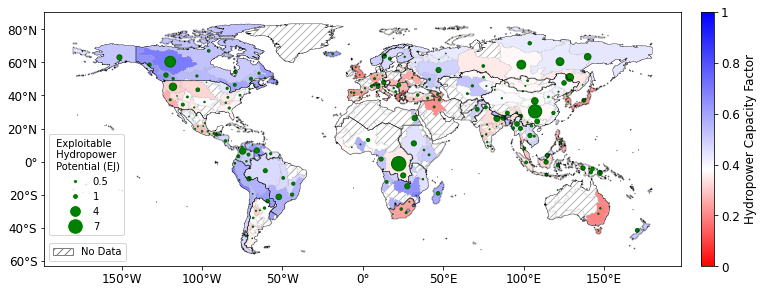

In [10]:
(fig, ax1) = plt.subplots(nrows=1, ncols=1,figsize=(12,6))    

cbarnorm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.38, vmax = 1) #set divergining colorbar with zero at center

fig1 = hydro_hep_cf_map.plot(ax=ax1 ,column='cf',legend=False, cmap='bwr_r',
                                 edgecolor='#b3b3b3', linewidth=0.2,norm=cbarnorm, alpha = 0.99,
                                 missing_kwds={"color": "w","edgecolor": '#b3b3b3',"hatch": "///","label": "No Data",},
                                 legend_kwds={'label': 'Historical CF','orientation':'vertical'})

fig1 = hydro_hep_cf_map['centroid'].plot(ax=ax1, 
                                         markersize=hydro_hep_cf_map.maxSubResource*35, c='green', edgecolor='darkgreen')

#label maps with lat/lon coordinates
ax1.set_xticks([-150,-100,-50,0,50,100,150]); ax1.set_yticks([-60,-40,-20,0,20,40,60,80])
ax1.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'], fontsize=12)
ax1.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'], fontsize=12)

nodata_patch =   mpatches.Patch(facecolor="none", edgecolor="grey", hatch = "///", label='No Data')
leg1 = ax1.legend(handles=[nodata_patch], loc=3, fontsize="10")
ax1.add_artist(leg1)

cbar = ax1.figure.colorbar(ax1.collections[0],fraction=0.019, pad=0.03)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel("Hydropower Capacity Factor", fontsize = 12) 

fig1= gcam_regions["geometry"].plot(ax=ax1, facecolor="none", edgecolor="black", linewidth=0.3)

line1 = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="green", marker='o', markersize=np.sqrt(0.5*35))
line2 = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="green", marker='o', markersize=np.sqrt(1*35))
line3 = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="green", marker='o', markersize=np.sqrt(4*35))
line4 = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="green", marker='o', markersize=np.sqrt(7*35))

ax1.legend((line1, line2, line3, line4), 
           ("0.5","1","4","7"), numpoints=1, bbox_to_anchor=(0, 0.1),
           loc = 'lower left', prop = { "size": 10 }, title=" Exploitable\n Hydropower \n Potential (EJ)")
